In [1]:

"""
@author: pickle0412
"""

import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from numpy import moveaxis
from skimage import io, transform
from torch.autograd import Variable
from PIL import Image
import pickle
import os
import glob
import pandas as pd
import random
import cv2
import plotly
# import bokeh
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [2]:
resnet = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /home/siddhantb/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 217800805/217800805 [00:09<00:00, 21818631.76it/s]


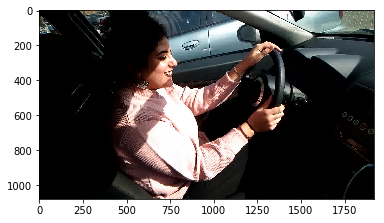

In [3]:
img = Image.open('AUCdata/v2_cam1_cam2_ split_by_driver/Camera 1/train/c0/1000.jpg')
plt.imshow(img)

In [19]:
transform = transforms.Compose([
            transforms.Resize(256),
#             transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [20]:
input_img = transform(img).unsqueeze(0)

In [21]:
input_img.shape

torch.Size([1, 3, 256, 455])

In [22]:
output_image = resnet(input_img)['out']

In [23]:
output_image.shape

torch.Size([1, 21, 256, 455])

In [24]:
om = torch.argmax(output_image.squeeze(), dim = 0).detach().cpu().numpy()

In [25]:
def decode_segmap(image, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background

               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle

               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),

               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow

               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),

               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person

               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),

               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor

               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):

        idx = image == l

        r[idx] = label_colors[l, 0]

        g[idx] = label_colors[l, 1]

        b[idx] = label_colors[l, 2]
        
    rgb = np.stack([r, g, b], axis=2)

    return rgb

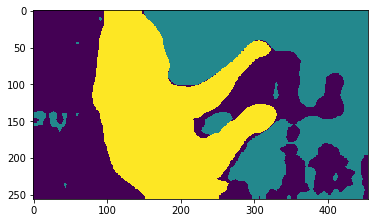

In [26]:
rgb_image = decode_segmap(om)
plt.imshow(om)

In [5]:
def load_train_dataset():
    data_path = 'AUCdata/v2_cam1_cam2_ split_by_driver/Camera 1/train/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
        transforms.Resize(size=(100, 100)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    )
    return train_dataset

def load_test_dataset():
    data_path = 'AUCdata/v2_cam1_cam2_ split_by_driver/Camera 1/test/'
    test_dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transforms.ToTensor()
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = 16,
        num_workers = 4,
        shuffle = False
    )
    return test_loader

In [6]:
dataset = load_train_dataset()
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

testLoader = load_test_dataset()

In [7]:
if torch.cuda.is_available():
    resnet.cuda()

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
learning_rate = 0.001

optimizer = torch.optim.Adam(resnet.parameters(), lr = learning_rate)

In [10]:
def train(model,dataloaderList,epochs, device = 'cpu',saveName=None):
    
    trainloader=dataloaderList[0]
    valloader=dataloaderList[1]

    valAccList=[]
    
    print('Start Training...')
    for epoch in range(epochs):
        running_loss=0
        
        for i_batch, (images, labels) in enumerate(trainloader):
            
            images=Variable(images,requires_grad=True).to(device)
            labels=Variable(labels).to(device)
            
            optimizer.zero_grad()
            
            outputs=model(images)

            loss=criterion(outputs,labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
            if i_batch%100 == 99:
                print('[%2d,%5d] Training Loss: %.3f'  % 
                      (epoch+1,i_batch+1,running_loss/100))
                running_loss = 0

               
        print('Validating the model')
        
        with torch.no_grad():
            valPreds=[]
            valLabels=[]
            for i_batch, (images, labels) in enumerate(valloader):
                
                images= images.to(device)
                labels= labels.numpy()
                
                preds=model(images)
                preds=preds.cpu().numpy()
                
                pred_labels=np.argmax(preds,axis=-1)
                valPreds.append(pred_labels)
                valLabels.append(labels)
            
            valPreds=np.concatenate(valPreds)
            valLabels=np.concatenate(valLabels)
            size=valPreds.shape[0]
            running_corrects=np.sum(valPreds==valLabels)
        
            acc=float(running_corrects)/size
            valAccList.append(acc)
            print('Accuracy after epoch %2d is %.3f' % (epoch+1,acc))
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'Model_weights/'+saveName+'.pt')
    
    print("Finished Training")
    print("Saving Model")
#     torch.save(model.state_dict(),'Model_weights/'+saveName+'.pt')
    
    return model,valAccList

In [ ]:
resnet_1, valAccList_1 = train(resnet, [train_loader, validation_loader], 15, device, 'resnet')

In [ ]:
with open('res_val_acc_list', 'wb') as f:
    pickle.dump(valAccList_1, f)

In [11]:
model = resnet
checkpoint = torch.load('Model_weights/resnet.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
resnet.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [12]:
with torch.no_grad():
            valPreds=[]
            valLabels=[]
            valAccList = []
            for i_batch, (images, labels) in enumerate(validation_loader):
                
                images= images.to(device)
                labels= labels.numpy()
                
                preds=model(images)
                preds=preds.cpu().numpy()
                
                pred_labels=np.argmax(preds,axis=-1)
                valPreds.append(pred_labels)
                valLabels.append(labels)
            
            valPreds=np.concatenate(valPreds)
            valLabels=np.concatenate(valLabels)
            size=valPreds.shape[0]
            running_corrects=np.sum(valPreds==valLabels)
        
            acc=float(running_corrects)/size
            valAccList.append(acc)
            print('Accuracy after 15 epochs is %.3f' % (acc))

Accuracy after 15 epochs is 0.896
